In [1]:
import torch
import random
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim

In [3]:
# Determine random seed
seed = random.randint(1, 10000)

In [4]:
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  5094


## Display and Prepare Training Images

In [5]:
# Define number of GPUs
# We use GPU instead of CPU here for efficiency and better quality
ngpu = 1

#### Compute Mean and Std

In [15]:
# Resize all images and centercrop
transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])

In [46]:
train = datasets.ImageFolder('input', transform=transform)

In [47]:
loader = DataLoader(train, batch_size=128, shuffle = True, num_workers=3)

In [5]:
batch = next(iter(loader))

In [6]:
batch[0].mean(),batch[0].std()

(tensor(0.6199), tensor(0.2795))

#### Prepare training dataset 

In [6]:
# Normalize using mean and std
transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
# I tested different batch size from 128 to 16
# smaller batch size gave faster and better results
train_data = datasets.ImageFolder('input', transform=transform)
dataloader = DataLoader(train_data, batch_size=16, shuffle = True, num_workers=3)

In [8]:
real_batch = next(iter(dataloader))

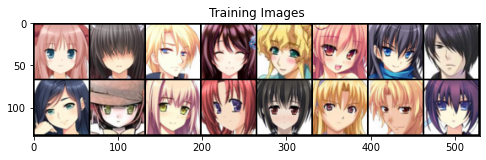

In [9]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
real_batch = next(iter(dataloader))
# Plot training images
plt.figure(figsize=(8, 8))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Weight Initialization

In [10]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generate 4x4 Pixels Images

I initially tried to use DCGAN architecture to reproduce 64x64 pixels images with shape 3x64x64. However, during actual implementation, it took a very long time to train one epoch and my kernel stops after multiple hours of training. I tried reducing batch sizes and reducing layers and parameters of the DCGAN architecture. However, I still could not successfully produce 64x64 pixel images. I then tested 32x32 pixels but still could not finish. Thus I eventually generate 4x4 pixel images and 16x16 pixels. I tested different layers and was able to go up to 5 layers with CovTranspose2d and BatchNorm2d.

In [11]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # latent vector Z with length 100
            # Transpose2d conv layer 1
            # Each ConvTranspose2d paied with BatchNorm2d
            nn.ConvTranspose2d(100, 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Transpose2d conv layer 2
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Transpose2d conv layer 3
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Transpose2d conv layer 4
            nn.ConvTranspose2d(8, 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            # Transpose2d conv layer 5
            nn.ConvTranspose2d(4, 3, 4, 2, 1, bias=False),
            # Tanh function here to produce output of same shape
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
# Create Generator
netG = Generator(ngpu).to(device)

# Handle multiple GPU if needed, here we only use 1
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply weight initialization function
netG.apply(weights_init)

# Print model architecture
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(4, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Discriminator with similar structure as the generator
            # LeakyRelu used here instead of Relu following guidelines of Radford et al.
            # Layer 1
            nn.Conv2d(3, 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 2
            nn.Conv2d(4, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 3
            nn.Conv2d(8, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 4
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # Layer 5
            nn.Conv2d(32, 1, 4, 1, 0, bias=False),
            # Sigmoid function here to determine probabilities indicating real images
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(32, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Optimizer 

In [15]:
# Choose BCELoss functions as suggestd by Radford et al. in DCGAN paper
criterion = nn.BCELoss()

# Random noises as latent vectors Z for input
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
# Determine real labels and fake labels for the discriminator
real_label = 1.0
fake_label = 0.0

# Choose Adam optimizers as suggestd by Radford et al. in DCGAN paper
# Also following guidelines from Radford et al., set learning rate = 0.0002 and beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

#### Training

In [18]:
num_epochs = 5

In [19]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/3973]	Loss_D: 1.1727	Loss_G: 0.9294	D(x): 0.5500	D(G(z)): 0.4275 / 0.4003
[0/5][1000/3973]	Loss_D: 0.2339	Loss_G: 2.8132	D(x): 0.8920	D(G(z)): 0.1081 / 0.0705
[0/5][2000/3973]	Loss_D: 0.1210	Loss_G: 3.4493	D(x): 0.9753	D(G(z)): 0.0830 / 0.0462
[0/5][3000/3973]	Loss_D: 0.5011	Loss_G: 1.7149	D(x): 0.7515	D(G(z)): 0.1130 / 0.2429
[1/5][0/3973]	Loss_D: 0.6551	Loss_G: 2.1289	D(x): 0.9122	D(G(z)): 0.3400 / 0.2231
[1/5][1000/3973]	Loss_D: 0.5624	Loss_G: 3.1860	D(x): 0.7742	D(G(z)): 0.1788 / 0.0570
[1/5][2000/3973]	Loss_D: 0.2315	Loss_G: 3.8019	D(x): 0.8780	D(G(z)): 0.0784 / 0.0466
[1/5][3000/3973]	Loss_D: 0.5709	Loss_G: 2.7901	D(x): 0.9057	D(G(z)): 0.3309 / 0.0979
[2/5][0/3973]	Loss_D: 0.2086	Loss_G: 2.8706	D(x): 0.9501	D(G(z)): 0.1233 / 0.0946
[2/5][1000/3973]	Loss_D: 0.2494	Loss_G: 4.3829	D(x): 0.8532	D(G(z)): 0.0368 / 0.0292
[2/5][2000/3973]	Loss_D: 0.2564	Loss_G: 5.6262	D(x): 0.8461	D(G(z)): 0.0434 / 0.0136
[2/5][3000/3973]	Loss_D: 0.3254	Loss_G: 3.4759	D

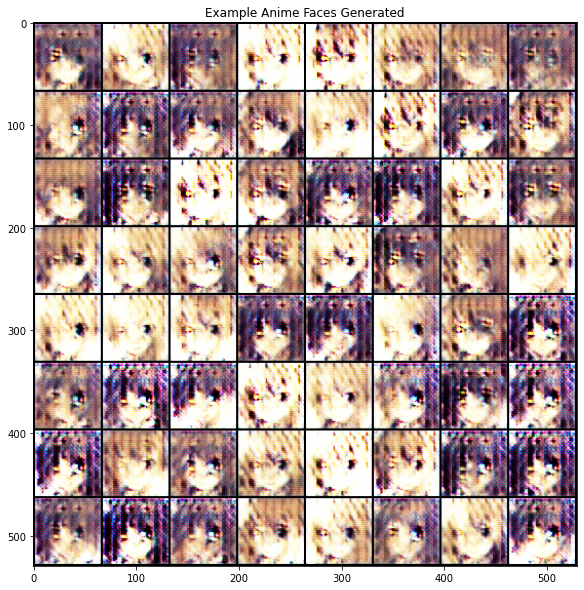

In [21]:
plt.figure(figsize=(10,10))
plt.title("Example Anime Faces Generated")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Generate 16x16 Pixels Images

In [22]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is latent space vector Z
            # size of z latent vector is 100 here
            # Transpose2d conv layer 1
            nn.ConvTranspose2d(100, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Transpose2d conv layer 2
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Transpose2d conv layer 3
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Transpose2d conv layer 4
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Transpose2d conv layer 5 to generate image
            # for colored image, the number of channels here is 3
            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            # Tanh Activation for final image
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [23]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
# Create the generator
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [24]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Optimizer

In [26]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [27]:
num_epochs = 10

#### Training 

In [29]:
#####################################################
#    Title: PyTorch Tutorials - DCGAN Tutorial
#    Author: Nathan Inkawhich
#    Availability: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#dcgan-tutorial
#
######################################################
img_list_N = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list_N.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/3973]	Loss_D: 0.1624	Loss_G: 3.6992	D(x): 0.9140	D(G(z)): 0.0594 / 0.0345
[0/10][1000/3973]	Loss_D: 0.4870	Loss_G: 5.2256	D(x): 0.9054	D(G(z)): 0.2725 / 0.0074
[0/10][2000/3973]	Loss_D: 0.4612	Loss_G: 3.4866	D(x): 0.7483	D(G(z)): 0.0530 / 0.0572
[0/10][3000/3973]	Loss_D: 0.3840	Loss_G: 4.3099	D(x): 0.8516	D(G(z)): 0.1390 / 0.0248
[1/10][0/3973]	Loss_D: 0.1133	Loss_G: 5.5330	D(x): 0.9605	D(G(z)): 0.0635 / 0.0069
[1/10][1000/3973]	Loss_D: 0.1945	Loss_G: 6.0114	D(x): 0.9323	D(G(z)): 0.0222 / 0.0054
[1/10][2000/3973]	Loss_D: 0.1494	Loss_G: 6.6151	D(x): 0.9870	D(G(z)): 0.1217 / 0.0024
[1/10][3000/3973]	Loss_D: 0.0824	Loss_G: 5.8181	D(x): 0.9934	D(G(z)): 0.0685 / 0.0074
[2/10][0/3973]	Loss_D: 0.0313	Loss_G: 7.0743	D(x): 0.9786	D(G(z)): 0.0091 / 0.0023
[2/10][1000/3973]	Loss_D: 0.0893	Loss_G: 5.7487	D(x): 0.9528	D(G(z)): 0.0294 / 0.0100
[2/10][2000/3973]	Loss_D: 0.0453	Loss_G: 4.8574	D(x): 0.9746	D(G(z)): 0.0181 / 0.0173
[2/10][3000/3973]	Loss_D: 0.2530	Loss

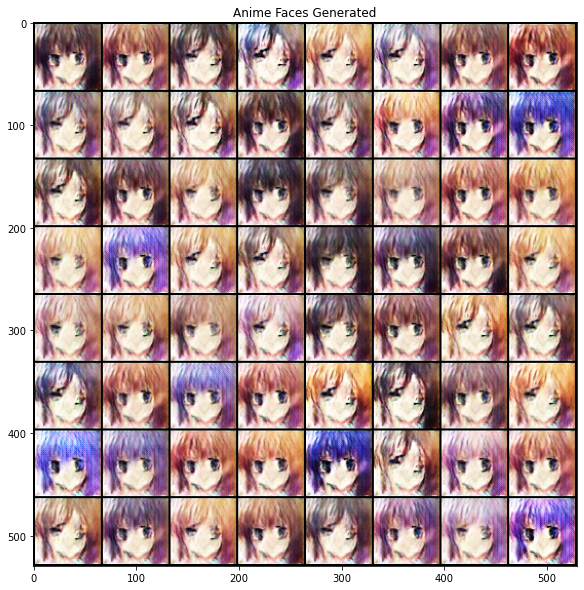

In [31]:
plt.figure(figsize=(10,10))
plt.title("Anime Faces Generated")
plt.imshow(np.transpose(img_list_N[-1],(1,2,0)))
plt.show()